## DSCI 100 Project Proposal Team 44
Melanie Law, Allen Zhu, Carlos Gerogescu, Hannah Ban

# Project Title: Determining The Best Predictors of Heart Disease

## Introduction

Heart disease or failure is a condition where the heart muscle of the afflicted cannot pump blood as efficiently due to a structural defect, compared to a person without the condition. Quick diagnosis and implementation of treatments may be able to drastically improve someone's chances of living through heart disease.

The question we will be trying to answer with our project is the following: What combination of relevant predictors will produce the most accurate prediction model?
In this project, we hope to accomplish the following:
1.	Make a training model that can accurately predict whether a person has heart disease given certain predictors.
2.	Determine the optimal predictors using forward selection.
3.	Determine the accuracy of our model and compare it to the accuracy of models built through the forward selection process.

We will be using the processed Cleveland data found under the Heart Disease Data Set provided by the UCI Machine Learning Repository (1). The main attributes we will be looking into include the ones numbered 1, 4, 5, 8, 10, and 12, as seen on the listed attributes on the website. Initially, there were 6 observations that contained missing information that we decided to remove from the overall data set we decided to use. All columns of the data set contain quantitative data with certain values corresponding to a meaning. (eg. cp of 1 = typical angina, 2 = atypical angina, 3 = non-anginal pain, 4 = asymptomatic). Note that we are only using numerical classifiers as we are using k-nn classification.
The following predictors we will be examining to answer our question are as follows: age, trestbps, chol, thalach, oldpeak, ca.

The following justifications below show our reasons on why we are using certain predictors and their relationship with heart disease.

**Age (age)**
- Aging is shown to increase cholesterol level (another predictor related to heart disease) (2).
- Age is related to other health factors such as risk of diabetes, frailty, obesity, and build-up of fatty deposits on artery walls, which is related to heart disease (3).

**Resting Blood Pressure (trestbps)**
- High blood pressure causes damage to the arteries, forcing the body to spend energy to constantly heal them, potentially increasing risk of heart disease (4).

**Cholesterol Level(chol)**
- High cholesterol levels cause the arteries to clog due to build-up of plaque, which in turn affects blood flow, and increases risk of stroke, angina, and other chest problems (5).

**Maximum Heart Rate Record (thalach)**
- High maximum heart rate shows that the heart is strong and healthy as it is also an indication of routine exercise and indicates a lower risk of heart disease (6).
- High aerobic capacity is associated with a lower risk of heart disease (6).

**ST depression induced by exercise relative to rest (oldpeak)**
- Patients with chest disease have been found to have ST depression segments on their ECG (7).
- ST depression segments are commonly associated with signs of chest and heart problems (7).

**Major vessels colour by flurosocopy (ca)**
- A greater number of vessels coloured by fluoroscopy is associated with a greater risk of getting heart disease and has been found to be linked to Coronary Artery disease (a type of heart disease) (8).



## Methods & Results

In [170]:
#Loading relevant libraries
library(tidyverse)
library(repr)
library(tidymodels)

In [171]:
set.seed(800)

#Read data in from UCI website
data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
                 col_names = FALSE )

#Add column names
attributes <-  c("age", 'sex','cp', 'trestbps', 'chol', 'fbs', 'restecg',
                 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num')
colnames(data) <- attributes

#Remove NA values and reformat data types to correct type
data <- data %>%
  mutate(oldpeak = as.numeric(oldpeak),
         ca = as.numeric(ca),
         thal = as.numeric(thal)) %>% 
  filter(!is.na(ca),
         !is.na(thal))

#Remove categorial predictors 
data <-  data %>% 
    select(-c(cp, fbs, restecg, exang, slope, thal))

#Convert the prediction label into a factor
data <- data %>%
  mutate(num = ifelse(num > 0,"disease","healthy")) %>% 
  mutate(num = as_factor(num)) %>% 
  mutate(sex = ifelse(sex == 1 ,"male","female"))

#head(data)

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_double(),
  X12 = col_character(),
  X13 = col_character(),
  X14 = col_double()
)

Warning message:
“Problem with `mutate()` input `ca`.
ℹ NAs introduced by coercion
ℹ Input `ca` is `as.numeric(ca)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”
Warning message:
“Problem with `mutate()` input `thal`.
ℹ NAs introduced by coercion
ℹ Input `thal` is `as.numeric(thal)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”


In [172]:
set.seed(800)

#Create training and testing datasets 
heart_split <- initial_split(data, prop = 0.80, strata = num)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)   

#head(heart_train)


A training and testing data split of 80/20 was deemed appropriate in order to increase the number of observations available for training while also having a testing dataset of sufficient size. In performing an 80/20 split, the training and testing datasets included 239 and 58 observations respectively.

### Exploratory Data Analysis
Explore the dataset by creating summary tables and figures to uncover trends in the data.

In [173]:
set.seed(800)

# Exploratory Tables ------------------------------------------------------

#Propotion of observations with heart disease and without 
heart_proportions <- heart_train %>% 
  group_by(num) %>% 
  summarize(n = n()) %>% 
  mutate(percent = 100*n/nrow(heart_train))%>%
  rename("disease" = num,
         "count" = n)

#Table containing summary statistics 
summary <- heart_train %>%
  select(-c(num,sex)) %>% 
  pivot_longer(everything()) %>%
  arrange(name) %>%
  group_by(name) %>%
  summarize(
    mean = mean(value),
    std_dev = sd(value),
    median = median(value),
    max = max(value),
    min = min(value),
    quartile.1 = quantile(value, 0.25),
    quartile.3 = quantile(value, 0.75)) %>%
  rename("predictor" = name)

#Number observations with and without heart disease by sex
num_char <- heart_train %>% 
  select(num, sex, age) %>% 
  group_by(num, sex) %>% 
  summarise(n = n())


`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` regrouping output by 'num' (override with `.groups` argument)



In [174]:
heart_proportions

disease,count,percent
<fct>,<int>,<dbl>
healthy,129,53.9749
disease,110,46.0251


##### **Table 1. Proportion of Patients with Heart Disease**
The incidence of heart disease is indicated by disease status. Those without heart disease as denoted as healthy. Proportion of patients with and without heart disease in the dataset is approximately the same. 

In [175]:
summary

predictor,mean,std_dev,median,max,min,quartile.1,quartile.3
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
age,54.5774059,9.2487378,56.0,77.0,29,47.0,61.0
ca,0.6987448,0.9577407,0.0,3.0,0,0.0,1.0
chol,249.3430962,53.4072614,244.0,564.0,126,211.5,279.5
oldpeak,1.0602510,1.1954613,0.8,6.2,0,0.0,1.6
thalach,150.0502092,23.0077990,153.0,202.0,71,138.0,165.0
trestbps,132.2217573,17.2150568,130.0,200.0,94,120.0,140.0


##### **Table 2. Summary Statistics of Predictors**
The scale of each predictor varies, necessitating the need to scale and balance predictors prior to model construction.

In [176]:
# Visualizations ----------------------------------------------------------

#Grouped barchart for sex vs heart disease
sex_bar_plot <- num_char %>% 
  ggplot(aes(x = num, y = n, fill = sex))+
  geom_bar(position="fill", stat="identity")+
  labs(x = "Heart Disease", y = "Patients", fill = "Sex")+
  theme_bw()+
  ggtitle("Presence of Heart Disease Across Gender")

#age box plot
age_box_plot <- heart_train %>% 
  ggplot(aes(x= as.factor(num), y = age))+
  geom_boxplot()+
  labs(x = "Heart Disease", y = "Age")+
  theme_bw()+
  ggtitle("Distribution of Age Across Heart Disease")

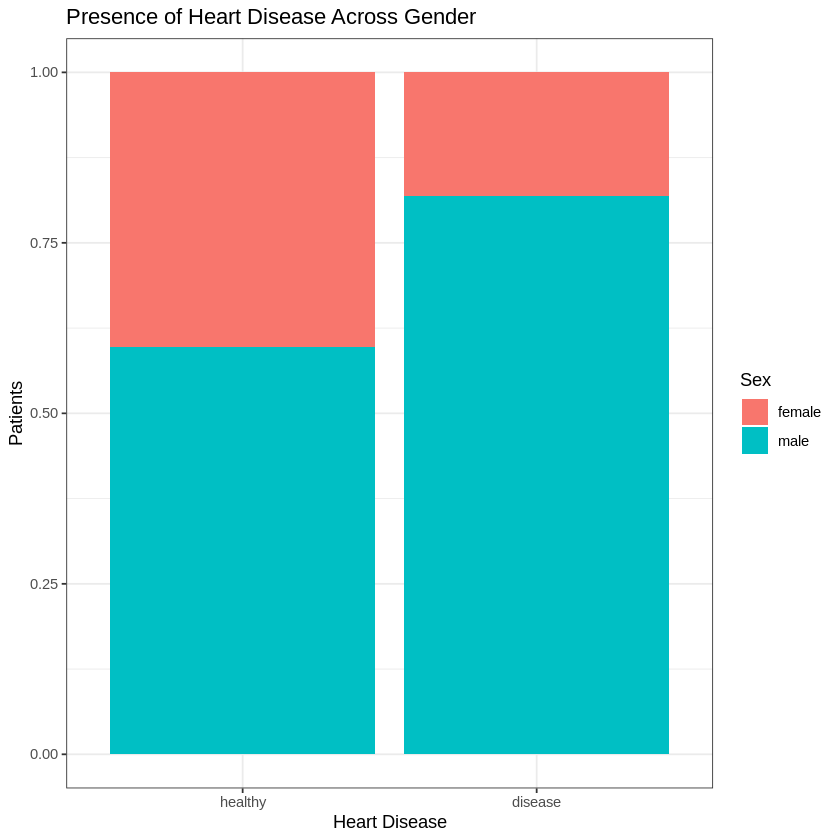

In [177]:
sex_bar_plot

##### **Figure 1. Incidence of Heart Disease Across Sex**
Men show a higher incidence of heart disease compared to women. Stratifying by sex could produce a more accurate classifier since men and women do not appear to be affected the same.

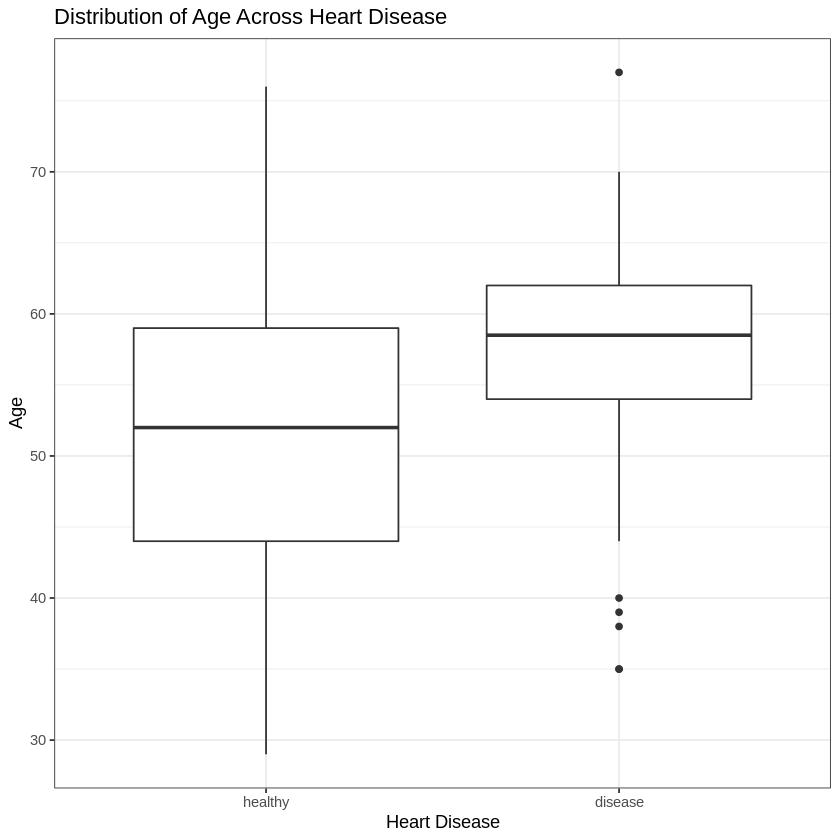

In [178]:
age_box_plot

##### **Figure 2. Distribution of Age Across Disease Status**
The median age of those with heart disease is greater than healthy individuals. Is possible that the classifier will be more accurate for predicting disease status for those aged 45-65, as the majority of individuals with heart disease fall in this age range.


### k-NN Classification

#### Determination of the most optimal value of K

In [179]:
set.seed(800)

#Create the model recipe
recipe <- recipe(num ~ age + trestbps + chol + thalach + oldpeak + ca,
                         data = heart_train) %>% 
  step_scale(all_predictors()) %>% 
  step_center(all_predictors())

#Create the model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) %>% 
  set_engine("kknn") %>% 
  set_mode("classification")

#Cross-validation
heart_vfold <- vfold_cv(heart_train,
                        v = 5,
                        strata = num)

#Combine above steps into a single workflow
knn_results <- workflow() %>% 
  add_recipe(recipe) %>% 
  add_model(knn_spec) %>% 
  tune_grid(resamples = heart_vfold, grid = 10) %>% 
  collect_metrics() 

accuracies <- knn_results %>% 
  filter(.metric == "accuracy")

To find the ideal k value we will use a line+point graph that plots neighbors vs estimated accuracies to identify what k value yields the most accurate results.

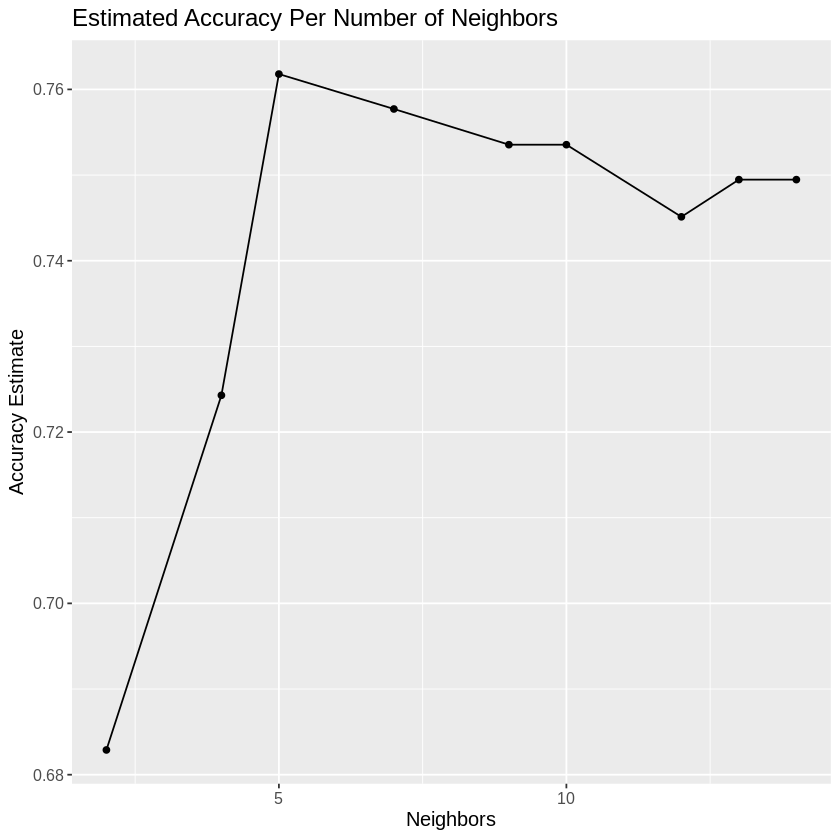

In [180]:
#Plot the estimated model accuracy vs number of neighbors
accuracy_vs_n <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12))+
  ggtitle("Estimated Accuracy Per Number of Neighbors")
accuracy_vs_n

##### **Figure 3. Estimated Accuracy Per Number of Neighbors**
The highest estimated accuracy was obtained when K = 5 was proceeded with for downstream analysis. K=5 was deemed suitable as variation in accuracy estimates changed less after this threshold.


In [181]:
set.seed(800)

#Retrain the classifier using the optimal K value determined above
knn_spec_rt <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) %>% 
  set_engine("kknn") %>% 
  set_mode("classification")

knn_fit_rt <- workflow() %>% 
  add_recipe(recipe) %>% 
  add_model(knn_spec_rt) %>% 
  fit(data = heart_train)

#Peform prediction on training data to compare with prediction on testing data.
#This step is performed to obtain sense for possible over/underfitting
heart_train_predictions <- predict(knn_fit_rt, heart_train) %>% 
  bind_cols(heart_train)

heart_metrics_train <- heart_train_predictions %>% 
  metrics(truth = num, estimate = .pred_class) %>% 
  filter(.metric == "accuracy")

# Training set predictions 
heart_metrics_train <- heart_metrics_train %>% 
    select(.estimate) %>% 
    pull()
heart_metrics_train

[1] 0.8242678

#### Predict Model Accuracy on Testing Data

In [182]:
set.seed(800)
heart_test_predictions <- predict(knn_fit_rt, heart_test) %>% 
  bind_cols(heart_test)

heart_metrics_test <- heart_test_predictions %>% 
  metrics(truth = num, estimate = .pred_class) %>% 
  filter(.metric == "accuracy")

#Testing set predictions
heart_metrics_test <- heart_metrics_test %>% 
    select(.estimate) %>% 
    pull()
heart_metrics_test

[1] 0.7931034

The testing data suggests that the model has an accuracy of 79%. Compared to an estimated accuracy of 82% on the training data, the model is likely not over or underfitting the data.

In [183]:
#Confusion matrix 

confusion <- heart_test_predictions %>% 
             conf_mat(truth = num , estimate = .pred_class)

confusion

          Truth
Prediction healthy disease
   healthy      24       5
   disease       7      22

##### **Table 3. Confusion Matrix from Testing Data Predictions**
The classifier labeled 46 out of 58 observations correctly. False positives and false negatives were also present. 7 observations were labeled as having heart disease when they were healthy and 5 observations with heart disease were labeled as healthy. 


### Forward Selection
#### Compare the selected predictors to what forward selection suggests are the optimal predictors.

In [184]:
set.seed(800)

#Predictor columns
names <- colnames(heart_train %>% select(-c(num, sex)))

#Tibble to store accuracies:
accuracies_fs <- tibble(size = integer(),
                     model_string = character(),
                     accuracy = numeric())

#create a model spec
knn_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) %>%
  set_engine("kknn") %>% 
  set_mode("classification")

#Create a 5-fold cross-validation object
heart_vfold <- vfold_cv(heart_train,
                        v = 5,
                        strata = num)

#Store the total number of predictors 
n_total <- length(names)

#Store selected predictors
selected <- c()


In [185]:
set.seed(800)
for (i in 1:n_total) {
  accs <- list()
  models <- list()
  for (j in 1:length(names)){
    preds_new <- c(selected, names[[j]])
    model_string <- paste("num", "~", paste(preds_new, collapse = '+'))
    
    #Create recipe from model string
    heart_recipe <- recipe(as.formula(model_string),
                            data = heart_train) %>% 
      step_scale(all_predictors()) %>% 
      step_center(all_predictors())
    
    #Tune KNN classifier with these predictors
    #collect accuracy for best k
    
    acc <- workflow() %>% 
      add_recipe(heart_recipe) %>% 
      add_model(knn_spec) %>% 
      tune_grid(resamples = heart_vfold, grid = 10) %>% 
      collect_metrics() %>% 
      filter(.metric == "accuracy") %>% 
      summarise(mx = max(mean))
    acc <- acc$mx %>% unlist()
    
    #add result to dataframe
    accs[[j]] <- acc
    models[[j]] <- model_string
  }
  jstar <- which.max(unlist(accs))
  accuracies_fs <- accuracies_fs %>% 
    add_row(size = i, 
            model_string = models[[jstar]], 
            accuracy = accs[[jstar]])
  selected <- c(selected, names[[jstar]])
  names <- names[-jstar]
}

In [186]:
#View the estimated model accuracy for each combination of predictors
accuracies_fs

size,model_string,accuracy
<int>,<chr>,<dbl>
1,num ~ ca,0.7403369
2,num ~ ca+oldpeak,0.7487589
3,num ~ ca+oldpeak+chol,0.7737589
4,num ~ ca+oldpeak+chol+age,0.7614362
5,num ~ ca+oldpeak+chol+age+thalach,0.7696809
6,num ~ ca+oldpeak+chol+age+thalach+trestbps,0.7990248


##### **Table 4. Estimated Accuracy vs Predictor Combinations**
As the number of predictors increases, so too does the model accuracy for that combination of predictors.


To find the best number of predictors, we will plot an estimated accuracy vs. number of predictors line and point graph.

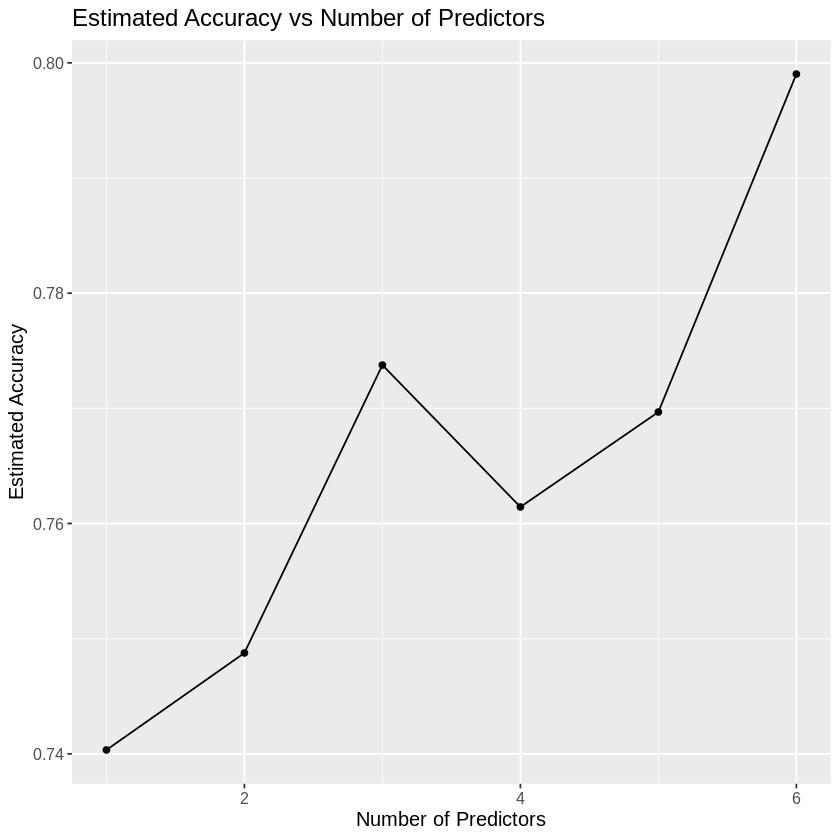

In [187]:
#Plot the accuracy per number of predictors
accuracy_vs_predictors <- ggplot(accuracies_fs, aes(x = size, y = accuracy)) +
  geom_point() +
  geom_line() +
  labs(x = "Number of Predictors", y = "Estimated Accuracy") + 
  theme(text = element_text(size = 12))+
  ggtitle("Estimated Accuracy vs Number of Predictors")
accuracy_vs_predictors

##### **Figure 5. Estimated Accuracy vs Number of Predictors**
There appears to be a strong positive linear trend between the number of predictors and the estimated model accuracy. No distinct elbow was observed in the plot. The highest estimated accuracy occurred when all 6 numerical predictors were included in the model.

## Discussion

### Main Findings
Based on literature review, all 6 numerical predictors in the dataset were suggested to be associated with heart disease. By building a k-NN classification model and performing K-tuning, it was found that the optimal number of neighbors was 5 and that the model was 79% accurate. A K-value of 5 was selected as the optimal number of neighbors due to a decreased rate of change in accuracy between nearby K values, suggesting that the model will likely be robust against uncertainty. Additionally, the highest estimated model accuracy was achieved at this threshold. Close values in the estimated model accuracy between the test (79%) and training data (82%) sets suggest that the model is likely not overfitting or underfitting the data. Hence it is able to reliably make consistent predictions for unseen data.

Out of 58 observations in the testing dataset, 46 were correctly labeled. Of the incorrect predictions, 7 observations were predicted as having heart disease when they were healthy and 5 were predicted as healthy when actually diseased. The detection of heart disease is considered a positive hit. An 8.6% false-negative rate is undesirable, as patients would not receive timely treatment. A false-positive rate of 12% is tolerable as it may indicate patients who are at high risk of heart disease and would undergo additional testing. 

To determine whether all 6 of these predictors were necessary for building a model with the highest accuracy, forward selection was performed to identify relevant and irrelevant predictors. It was found that a model that included all 6 predictors produced the highest model accuracy at 80%. When the predictors age and thalach were included in the model, there was a slight decrease in model accuracy. However, because this change was about 0.01 or lower, these predictors were still considered relevant. The results of the forward selection support our decision and initial model that the inclusion of all 6 predictors is relevant for building more accurate models for heart disease prediction.

### Expectations
As we were able to find supporting literature for each predictor’s relation to heart disease, the relevancy of all predictors included in our model was as expected. Through forward selection, the results also showed that some predictors such as age were less relevant than others as seen by their effect on the estimated model accuracy. 

What was unexpected was an accuracy rate of only 80%. For diagnostic applications, this rate is likely not high enough as mislabelling can have serious implications on the health outcomes of individuals mislabelled. This suggests that the model could be improved by including more numerical predictors relevant to heart disease not included in this dataset.

### Implications
Given our results above, we conclude that all six predictors used are beneficial to increasing model accuracy. This result suggests that these predictors are adequate classifiers of heart disease and should be included in future models for classifying heart disease. Thus, these findings could help practitioners diagnose heart disease more accurately, by only considering relevant predictor metrics.

However, our prediction accuracy rate with all six predictors is shown to be 80%. Thus, there remains a possibility of other classifiers that may increase the model accuracy rate. Therefore, as data scientists strive to improve their models, these findings may spur more experimentation and research in finding other classifiers that might be relevant to heart disease and increase model accuracy. Knowing the relevant predictors will also provide scientists a direction for research, and thus help them find factors that are likely to be relevant than not. (eg. scientists may research more into cholesterol, etc.). 

With regards to impact on patient treatment, by identifying what metrics are relevant to the prognosis of heart disease, the metrics could also be tracked to monitor patient progression and aid in a response to treatment.

Knowing relevant factors could also improve the diagnosis of heart disease, as classifiers with these relevant predictors could be used to perform a preliminary screen on who is likely to have heart disease and requires a more extensive follow-up for an official diagnosis. As a result, these findings could also improve the efficiency, cost, and accuracy of the diagnosis of heart disease.

### Future Questions 
Future questions from our findings include the following. Since only using the Cleveland data provided by the whole heart disease dataset, will the results of other geographic locations be different from Cleveland? Will the difference be significant? Additionally, would a larger sample size provide more accurate generalizations for global populations? 

Furthermore, because only the Cleveland dataset was used to train the classifier, it is possible that only considering this data set may have introduced a geographical bias. As such, a future direction could be to analyze the accuracy of the classifier in predicting heart disease for different countries (developed vs undeveloped countries), and see if the background of where a person lives affects model accuracy in predicting of heart disease. 

A further direction could be to identify additional numerical predictors, not included in this dataset, that could improve model accuracy. To include non-numerical predictors in predicting whether an individual has heart disease or now, other classification models aside from k-NN classification could also be explored and evaluated against k-NN classification. These other predictors relevant to heart disease could include whether a person has prior health complications if a person was ever pregnant or not, and if they have a family history of heart problems

Another follow-up direction would be to investigate if the prediction of heart disease can be sub-categorized into different heart disease types and see which indicator has the biggest impact on predicting which type. Different heart disease types that can be investigated include heart valve disease, congenital heart disease, and heart arrhythmias.
 

## References

1. Heart Disease Data Set. (1988, July 1). UCI Machine Learning Repository. Retrieved March 5, 2022, from https://archive.ics.uci.edu/ml/datasets/Heart+Disease
2. U.S. Department of Health and Human Services. (n.d.). Heart health and aging. National Institute on Aging. Retrieved April 2, 2022, from https://www.nia.nih.gov/health/heart-health-and-aging  
3. Rodgers, J. L., Jones, J., Bolleddu, S. I., Vanthenapalli, S., Rodgers, L. E., Shah, K., Karia, K., & Panguluri, S. K. (2019, April 27). Cardiovascular risks associated with gender and aging. Journal of cardiovascular development and disease. Retrieved April 4, 2022, from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6616540/ 
4. UT Southwestern Medical Center. (2016, June 6). Retrieved April 2, 2022, from https://utswmed.org/medblog/high-blood-pressure-heart-disease/ 
5. WebMD. (2020, July 2). Cholesterol and heart disease. WebMD. Retrieved April 2, 2022, from https://www.webmd.com/heart-disease/guide/heart-disease-lower-cholesterol-risk 
6. What your heart rate is telling you. Harvard Health. (2020, August 30). Retrieved April 3, 2022, from https://www.health.harvard.edu/heart-health/what-your-heart-rate-is-telling-you 
7. Pollehn, T., Brady, W. J., Perron, A. D., & Morris, F. (2002, March 1). The electrocardiographic differential diagnosis of st segment depression. Emergency Medicine Journal. Retrieved April 4, 2022, from https://emj.bmj.com/content/19/2/129 
8. Project McNulty: Estimating the risk of heart disease. CH. (2015, May 15). Retrieved April 3, 2022, from https://lucdemortier.github.io/projects/3_mcnulty 

## Appendix

| Attribute      | Description |
| ----------- | ----------- |
| age         | age       |
| sex         | sex         |
| cp          | chest pain |
| trestbps    | resting blood pressure |
| chol        | cholesterol |
| fbs         | fasting blood sugar |
| restecg     | resting electrocardiographic results |
| thalach     | maximum heart rate record |
| exang       | exercise induced angia |
| oldpeak     | ST depression indiced by exercise relative to rest |
| slope       | slope of peak exercise ST segment |
| ca          | number of major vessels coloured by fluoroscopy |
| thal        | thalassemia |
| num         | predicted attribute |



